# PCA using similarity matching
Demonstrating principal component analysis (PCA) using a similarity matching circuit.

In [1]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch import nn

from pynsm import SimilarityMatching

## Generate a dataset
Using a multivariate Gaussian with a variety of scales.

In [2]:
torch.manual_seed(0)

n_samples = 50_000
scales = torch.tensor([1.5, 1.2, 0.8, 0.2, 0.1])
input_dim = len(scales)

# generate a random covariance matrix with given scales
u, _ = torch.linalg.qr(torch.randn((input_dim, input_dim)))
s = torch.diag(scales ** 2)
cov = u @ s @ u.T

# generate the actual data
gauss = torch.distributions.MultivariateNormal(torch.zeros(input_dim), cov)
samples = gauss.sample(sample_shape=(n_samples,))

Make a loader for training.

In [3]:
batch_size = 1000
dataset = torch.utils.data.TensorDataset(samples)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Train similarity-matching circuit

In [4]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

output_dim = 3
encoder = nn.Linear(input_dim, output_dim, bias=False)
model = SimilarityMatching(
    encoder,
    out_channels=output_dim,
    tau=0.5,
    max_iterations=100,
    tol=1e-5,
    iteration_lr=0.1,
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

n_batches = n_samples // batch_size
assert n_samples % batch_size == 0
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda i: max(1.0 / (1.0 + 20 * (i / n_batches) ** 0.5), 0.01)
)

t0 = time.time()
running_loss = []
inputs = []
outputs = []
pbar = tqdm(train_loader)
for sample, in pbar:
    sample = sample.to(device)

    output = model(sample)
    loss = model.loss(sample, output)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    running_loss.append(loss.item())
    inputs.append(sample.detach().cpu())
    outputs.append(output.detach().cpu())

    pbar.set_postfix({"loss": running_loss[-1]}, refresh=False)

t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds.")

Running on cpu.


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 108.52it/s, loss=-2.9] 

Training took 0.47 seconds.


Show learning curve.

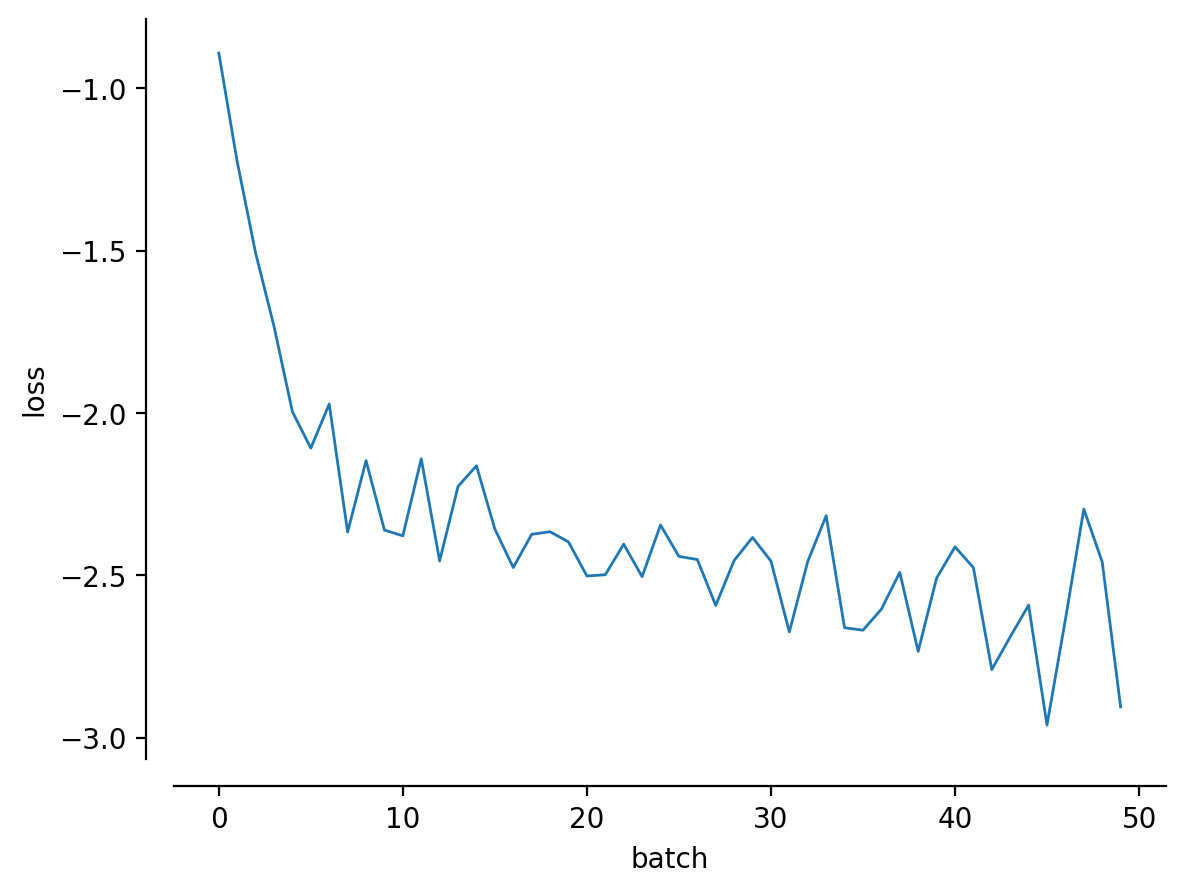

In [5]:
fig, ax = plt.subplots()
ax.plot(running_loss, lw=1.0)
ax.set_xlabel("batch")
ax.set_ylabel("loss")
sns.despine(ax=ax, offset=10)

Calculate loss function in rolling window.

In [6]:
window_size = 2000
window_step = 500

idxs = []
nsm_loss = []

inputs_v = np.vstack(inputs)
outputs_v = np.vstack(outputs)
total_samples = len(outputs_v)
for i in tqdm(range(0, total_samples - window_size, window_step)):
    x = inputs_v[i : i + window_size]
    y = outputs_v[i : i + window_size]

    x_cov = x @ x.T
    y_cov = y @ y.T

    loss = np.sum((x_cov - y_cov) ** 2) / window_size**2

    idxs.append(i + window_size / 2)
    nsm_loss.append(loss)

idxs = np.asarray(idxs)
nsm_loss = np.array(nsm_loss)

100%|██████████| 96/96 [00:00<00:00, 104.02it/s]


Show evolution of loss.

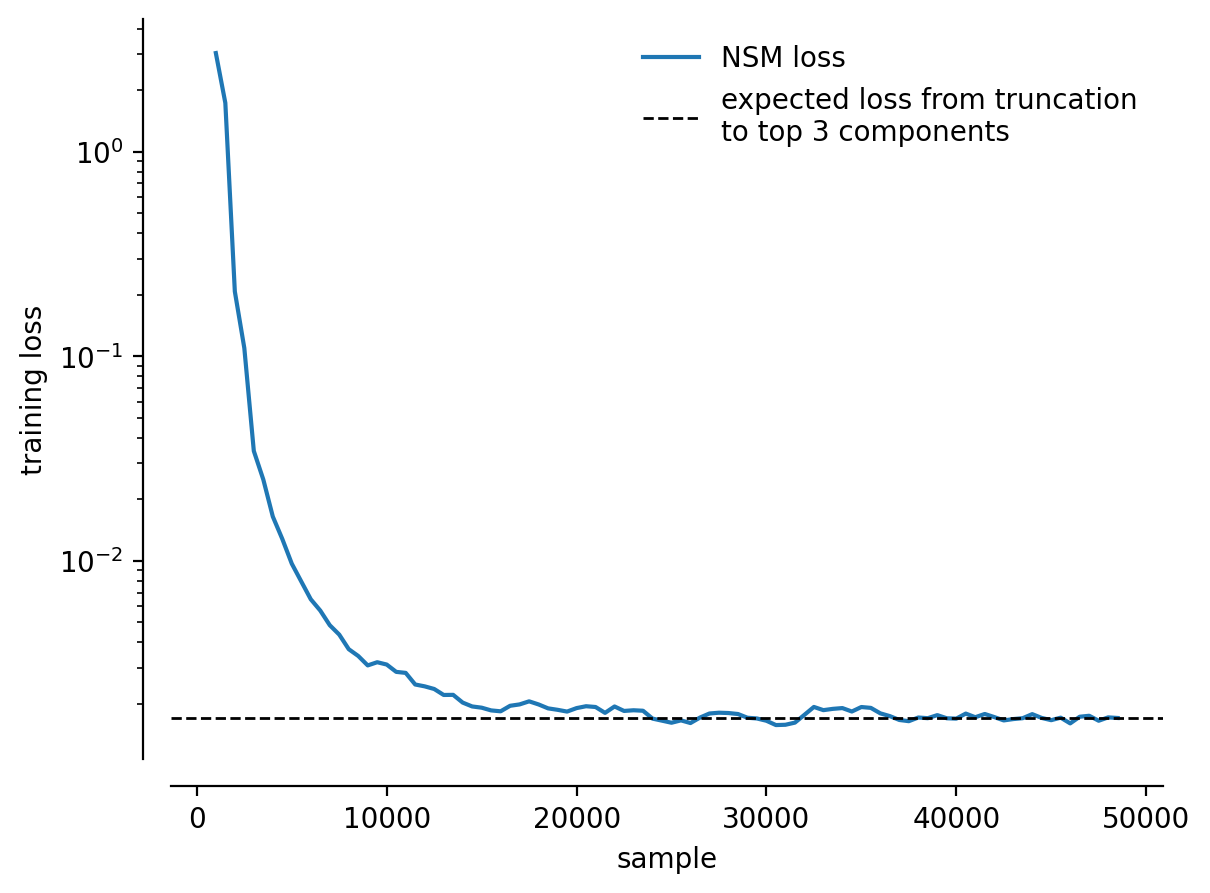

In [7]:
_, ax = plt.subplots()
ax.semilogy(idxs, nsm_loss, c="C0", label="NSM loss")
ax.set_xlabel("sample")
ax.set_ylabel("training loss")

expected_residual = sum(_**4 for _ in scales[output_dim:])
ax.axhline(
    expected_residual,
    c="k",
    lw=1.0,
    ls="--",
    label=f"expected loss from truncation\nto top {output_dim} components",
)

ax.legend(frameon=False)
sns.despine(ax=ax, offset=10)